In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 33% 5.00M/15.1M [00:00<00:00, 31.2MB/s]
100% 15.1M/15.1M [00:00<00:00, 77.8MB/s]


In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os
import glob
import cv2
from tqdm.notebook import tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, MaxPooling2D
from keras.layers import BatchNormalization, GlobalAveragePooling2D, Flatten


In [ ]:
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
x = []
y = []

# Process images in the "yes" folder
os.chdir('/content/yes')
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    img = cv2.resize(img, (224, 224))
    x.append(img)
    y.append('Y')  # Use 'Y' to denote "yes" images

# Process images in the "no" folder
os.chdir('/content/no')
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    img = cv2.resize(img, (224, 224))
    x.append(img)
    y.append('N')  # Use 'N' to denote "no" images



  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
from sklearn.utils import shuffle
x, y = shuffle(x, y, random_state=101)

# Convert lists to numpy arrays
x = np.array(x)
y = np.array(y)

In [ ]:
print(f"Shape of X: {x.shape}")
print(f"Shape of Y: {y.shape}")

Shape of X: (253, 224, 224, 3)
Shape of Y: (253,)


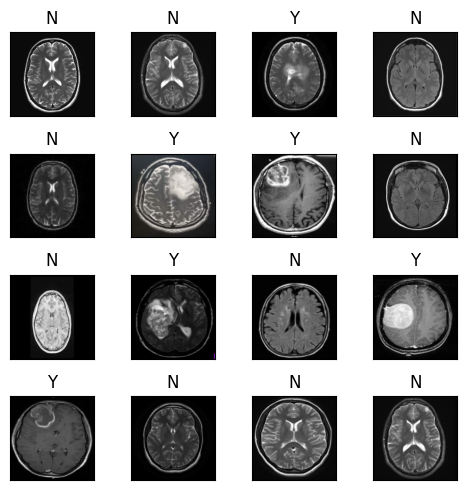

In [ ]:
import matplotlib.pyplot as plt

# Plotting the first 16 images in the dataset
plt.figure(figsize=(5, 5))  # Set the figure size
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x[i])
    plt.title(y[i])  # Optionally, add the label as the title

plt.tight_layout()
plt.show()


In [ ]:
# First split: 80% training, 20% remaining (which will be split into validation and test)
x_train, x_remaining, y_train, y_remaining = train_test_split(x, y, test_size=0.2, random_state=42)

# Second split: Split remaining set into 50% validation and 50% test (10% each of the original dataset)
x_val, x_test, y_val, y_test = train_test_split(x_remaining, y_remaining, test_size=0.5, random_state=42)

# Verify the shapes of the splits
print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")


Training set: (202, 224, 224, 3), (202,)
Validation set: (25, 224, 224, 3), (25,)
Test set: (26, 224, 224, 3), (26,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
le = LabelEncoder()

# Encode labels for training set
y_train = le.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)

# Encode labels for test set
y_test = le.transform(y_test)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Encode labels for validation set
y_val = le.transform(y_val)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=2)

# Print shapes for verification
print(f"Shape of X_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Validation set: {x_val.shape}")
print(f"Validation set: {y_val.shape}")


Shape of X_train: (202, 224, 224, 3)
Shape of y_train: (202, 2)
Shape of X_test: (26, 224, 224, 3)
Shape of y_test: (26, 2)
Validation set: (25, 224, 224, 3)
Validation set: (25, 2)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the convolutional base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))  # 2 classes: 'Y' and 'N'


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 1

In [ ]:
history = model.fit(x_train, y_train, epochs=15, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/15
7/7 [==============================] - 150s 21s/step - loss: 12.8289 - accuracy: 0.5743 - val_loss: 2.1561 - val_accuracy: 0.6400
Epoch 2/15
7/7 [==============================] - 145s 21s/step - loss: 3.2569 - accuracy: 0.7673 - val_loss: 0.5416 - val_accuracy: 0.8400
Epoch 3/15
7/7 [==============================] - 145s 21s/step - loss: 1.6419 - accuracy: 0.8069 - val_loss: 0.6607 - val_accuracy: 0.9200
Epoch 4/15
7/7 [==============================] - 145s 21s/step - loss: 0.6235 - accuracy: 0.8762 - val_loss: 0.6182 - val_accuracy: 0.8800
Epoch 5/15
7/7 [==============================] - 155s 22s/step - loss: 0.3771 - accuracy: 0.9109 - val_loss: 0.5114 - val_accuracy: 0.9200
Epoch 6/15
7/7 [==============================] - 147s 21s/step - loss: 0.4153 - accuracy: 0.8861 - val_loss: 0.4349 - val_accuracy: 0.8400
Epoch 7/15
7/7 [==============================] - 147s 21s/step - loss: 0.3504 - accuracy: 0.9010 - val_loss: 0.3231 - val_accuracy: 0.9200
Epoch 8/15
7/7 [===

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

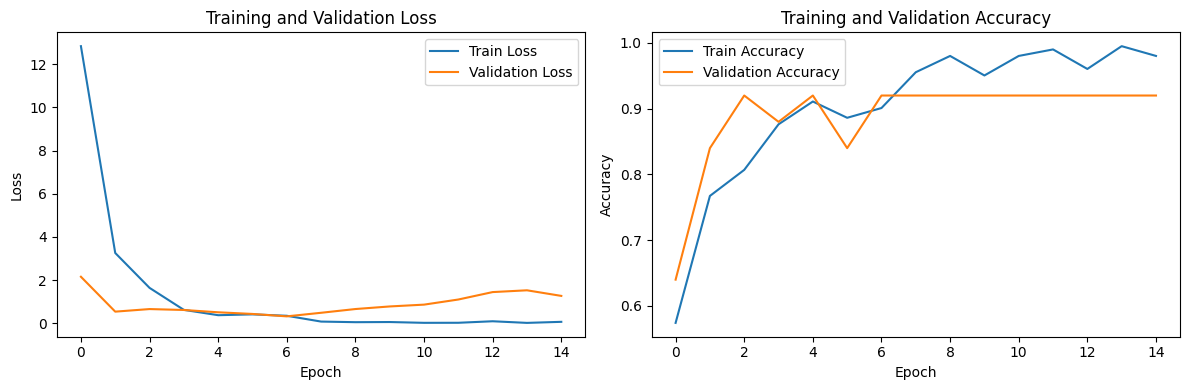

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

1/1 [==============================] - 16s 16s/step - loss: 0.3837 - accuracy: 0.9615
Test Loss: 0.3837
Test Accuracy: 0.9615


1/1 [==============================] - 1s 533ms/step


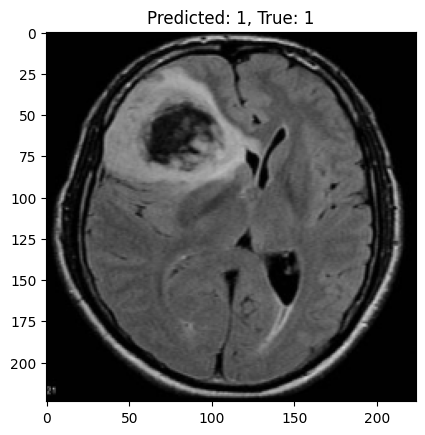

In [ ]:
# prompt: predict random pick image if it yes or no also show the image predicted

# Choose a random image from the test set
index = np.random.randint(0, len(x_test))
image = x_test[index]

# Predict the image
prediction = model.predict(np.expand_dims(image, axis=0))[0]

# Get the predicted class label
predicted_class = np.argmax(prediction)

# Get the true class label
true_class = np.argmax(y_test[index])

# Plot the image
plt.imshow(image, cmap="gray")
plt.title(f"Predicted: {predicted_class}, True: {true_class}")
plt.show()



1/1 [==============================] - 17s 17s/step


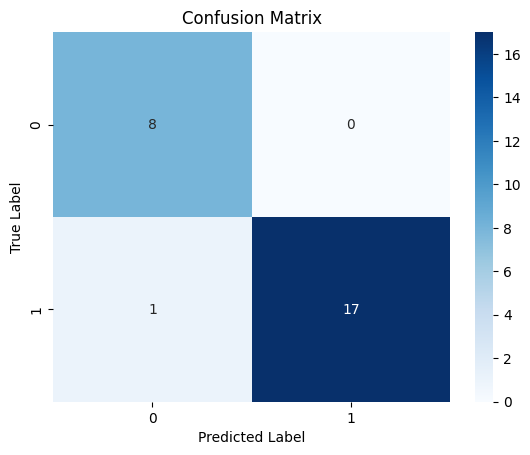

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
y_pred = model.predict(x_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true class labels
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# prompt: calculate the f1,recall and precision score

from sklearn.metrics import f1_score, recall_score, precision_score

# Calculate F1 score
f1 = f1_score(y_true, y_pred_classes)

# Calculate recall score
recall = recall_score(y_true, y_pred_classes)

# Calculate precision score
precision = precision_score(y_true, y_pred_classes)

# Print the scores
print(f"F1 Score: {f1:.4f}")
print(f"Recall Score: {recall:.4f}")
print(f"Precision Score: {precision:.4f}")


F1 Score: 0.9714
Recall Score: 0.9444
Precision Score: 1.0000


In [ ]:
import pickle

file_name = 'trained_model.sav'
pickle.dump(model, open(file_name, 'wb'))

In [ ]:
loaded_model = pickle.load(open('trained_model.sav', 'rb'))

1/1 [==============================] - 1s 543ms/step
Predicted class: 0


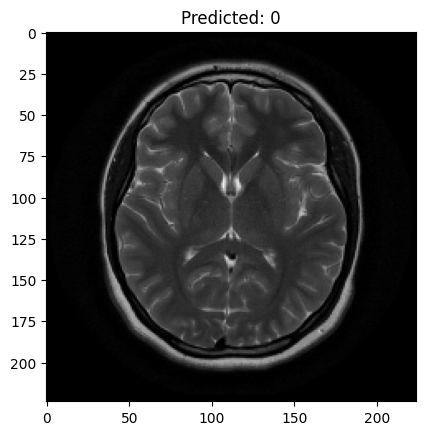

In [ ]:
image_path = '/content/1.jpeg'  # Replace with the actual image path
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))

# Predict the image
prediction = loaded_model.predict(np.expand_dims(image, axis=0))[0]

# Get the predicted class label
predicted_class = np.argmax(prediction)

# Print the prediction
print(f"Predicted class: {predicted_class}")

plt.imshow(image, cmap="gray")
plt.title(f"Predicted: {predicted_class}")
plt.show()

In [ ]:
# prompt: download this file trained_model.sav

from google.colab import files

files.download('trained_model.sav')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('BrainScan_architecture_Model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pickle

with open('BrainScan_ML_model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [ ]:
from google.colab import files

# Download the .h5 model file
files.download('BrainScan_architecture_Model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 1s 709ms/step
Predicted class: 1


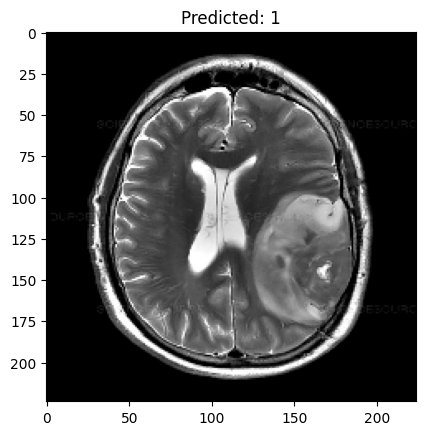

In [ ]:
import numpy as np

# Load the model
loaded_model = tf.keras.models.load_model('BrainScan_architecture_Model.h5')

# Load the image
image_path = '/content/2.jpg'  # Replace with the actual image path
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))

# Predict the image
prediction = loaded_model.predict(np.expand_dims(image, axis=0))[0]

# Get the predicted class label
predicted_class = np.argmax(prediction)

# Print the prediction
print(f"Predicted class: {predicted_class}")

plt.imshow(image, cmap="gray")
plt.title(f"Predicted: {predicted_class}")
plt.show()